In [1]:
import pandas as pd
import sklearn
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import scipy 
import arcgis

In [2]:
from arcgis.gis import GIS
from arcgis.features import GeoAccessor,GeoSeriesAccessor
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import ols

In [3]:
%matplotlib inline
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from math import sqrt
from scipy import stats

In [12]:
# read data
gis = GIS()
kc_data = pd.read_csv(r'~\Documents\Flatiron\data\data\Combined_new_data.csv', encoding='ISO-8859-1')

In [13]:
#fitting our model by dropping features that dont do much & transforming others into 
#useful data points through multiplying them 
#removing homes with horrible bed to bath ratios 
kc_data['PropName'].astype(str)
kc_data['PlatLot'].astype(str)
kc_data['PlatBlock'].astype(str)
kc_data['QuarterSection'].astype(str)
kc_data['PropType'].astype(str)
kc_data['DistrictName'].astype(str)
kc_data['CurrentZoning'].astype(str)

kc_data['sqft_abv_x_living'] = kc_data['sqft_above']*kc_data['sqft_living']
kc_data['sqft_x_grade'] = kc_data['sqft_abv_x_living']*kc_data['grade']
kc_data['sqft_15'] = kc_data['sqft_living15']*kc_data['sqft_lot15']
kc_data['view'].replace({0.19648 : 0 })
kc_data['waterfront'].replace({0.007596 : 0})
kc_data = kc_data.replace({'?': 0})
kc_data = kc_data.replace({'': 0})
kc_data = kc_data.replace({' ': 0})
kc_data = kc_data.replace({'N': 0})
kc_data = kc_data.replace({'Y': 0})
kc_data = kc_data.fillna(0)


kc_data = kc_data.loc[kc_data['floors'] <= 3]
kc_data = kc_data.drop('date', axis=1)#.drop('sqft_above', axis=1).drop('id', axis=1)
#kc_data = kc_data.drop('sqft_living', axis=1).drop('sqft_basement', axis=1)

In [20]:
kc_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5248 entries, 0 to 5248
Columns: 101 entries, id to sqft_15
dtypes: bool(1), float64(10), int64(82), object(8)
memory usage: 4.0+ MB


In [7]:
#filtering by zscore where applicable 
#not applicable: zipcode, yr built(wouldn't want to exclude all recent homes)
# year renovated, basement sqft, view & waterfront (usually 0), floors (only 4, certainly already outlier free)

kc_columns = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition',
               'grade','sqft_above','yr_built','yr_renovated','zipcode','lat','long','sqft_living15','sqft_lot15',
               'Township','Section','Area','SubArea','LevyCode','HBUAsIfVacant','HBUAsImproved','PresentUse',
               'SqFtLot', 'WaterSystem','SewerSystem','Access','Topography','StreetSurface','RestrictiveSzShape',
               'InadequateParking','PcntUnusable','MtRainier','Olympics','Cascades','Territorial','SeattleSkyline',
               'PugetSound','LakeWashington','LakeSammamish','SmallLakeRiverCreek','OtherView','WfntLocation',
               'WfntFootage',
'WfntBank',
'WfntPoorQuality',
'WfntRestrictedAccess',
'WfntAccessRights',
'WfntProximityInfluence',
'TidelandShoreland',
'LotDepthFactor',
'TrafficNoise',
'AirportNoise',
'PowerLines',
'OtherNuisances',
'NbrBldgSites',
'Contamination',
'DNRLease',
'AdjacentGolfFairway',
'AdjacentGreenbelt',
'HistoricSite',
'CurrentUseDesignation',
'NativeGrowthProtEsmt',
'Easements',
'OtherDesignation',
'DeedRestrictions',
'DevelopmentRightsPurch',
'CoalMineHazard',
'CriticalDrainage',
'ErosionHazard',
'LandfillBuffer',
'HundredYrFloodPlain',
'SeismicHazard',
'LandslideHazard',
'SteepSlopeHazard',
'Stream',
'Wetland',
'SpeciesOfConcern',
'SensitiveAreaTract',
'WaterProblems',
'TranspConcurrency',
'OtherProblems',
'sqft_abv_x_living',
'sqft_x_grade',
'sqft_15']

zscore_columns = []

for col in kc_columns:
    col_zscore = str(col + '_zscore')
    kc_data[col_zscore] = (kc_data[col] - kc_data[col].mean())/kc_data[col].std(ddof=0)
    zscore_columns.append(col_zscore)

for column in zscore_columns:
    kc_data = kc_data.loc[kc_data[column] < 2.90]
    kc_data = kc_data.loc[kc_data[column] > (-2.90)]

In [8]:
kc_data['bdscr_n_sqft_lv_scr'] = kc_data['bedrooms']*kc_data['sqft_living']
kc_data['lat_n_long'] = kc_data['lat']*kc_data['long']

#didn't help 
kcy = kc_data[['price']].copy()
kcx = kc_data[['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition',
               'grade','sqft_above','yr_built','yr_renovated','zipcode','lat','long','sqft_living15','sqft_lot15',
               'Township','Section','Area','SubArea','LevyCode','HBUAsIfVacant','HBUAsImproved','PresentUse',
               'SqFtLot', 'WaterSystem','SewerSystem','Access','Topography','StreetSurface','RestrictiveSzShape',
               'InadequateParking','PcntUnusable','MtRainier','Olympics','Cascades','Territorial','SeattleSkyline',
               'PugetSound','LakeWashington','LakeSammamish','SmallLakeRiverCreek','OtherView','WfntLocation',
               'WfntFootage',
'WfntBank',
'WfntPoorQuality',
'WfntRestrictedAccess',
'WfntAccessRights',
'WfntProximityInfluence',
'TidelandShoreland',
'LotDepthFactor',
'TrafficNoise',
'AirportNoise',
'PowerLines',
'OtherNuisances',
'NbrBldgSites',
'Contamination',
'DNRLease',
'AdjacentGolfFairway',
'AdjacentGreenbelt',
'HistoricSite',
'CurrentUseDesignation',
'NativeGrowthProtEsmt',
'Easements',
'OtherDesignation',
'DeedRestrictions',
'DevelopmentRightsPurch',
'CoalMineHazard',
'CriticalDrainage',
'ErosionHazard',
'LandfillBuffer',
'HundredYrFloodPlain',
'SeismicHazard',
'LandslideHazard',
'SteepSlopeHazard',
'Stream',
'Wetland',
'SpeciesOfConcern',
'SensitiveAreaTract',
'WaterProblems',
'TranspConcurrency',
'OtherProblems',
'sqft_abv_x_living',
'sqft_x_grade',
'sqft_15']].copy()

C:\Users\fenne\anaconda3\lib\site-packages\seaborn\matrix.py:204: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\fenne\anaconda3\lib\site-packages\seaborn\matrix.py:209: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


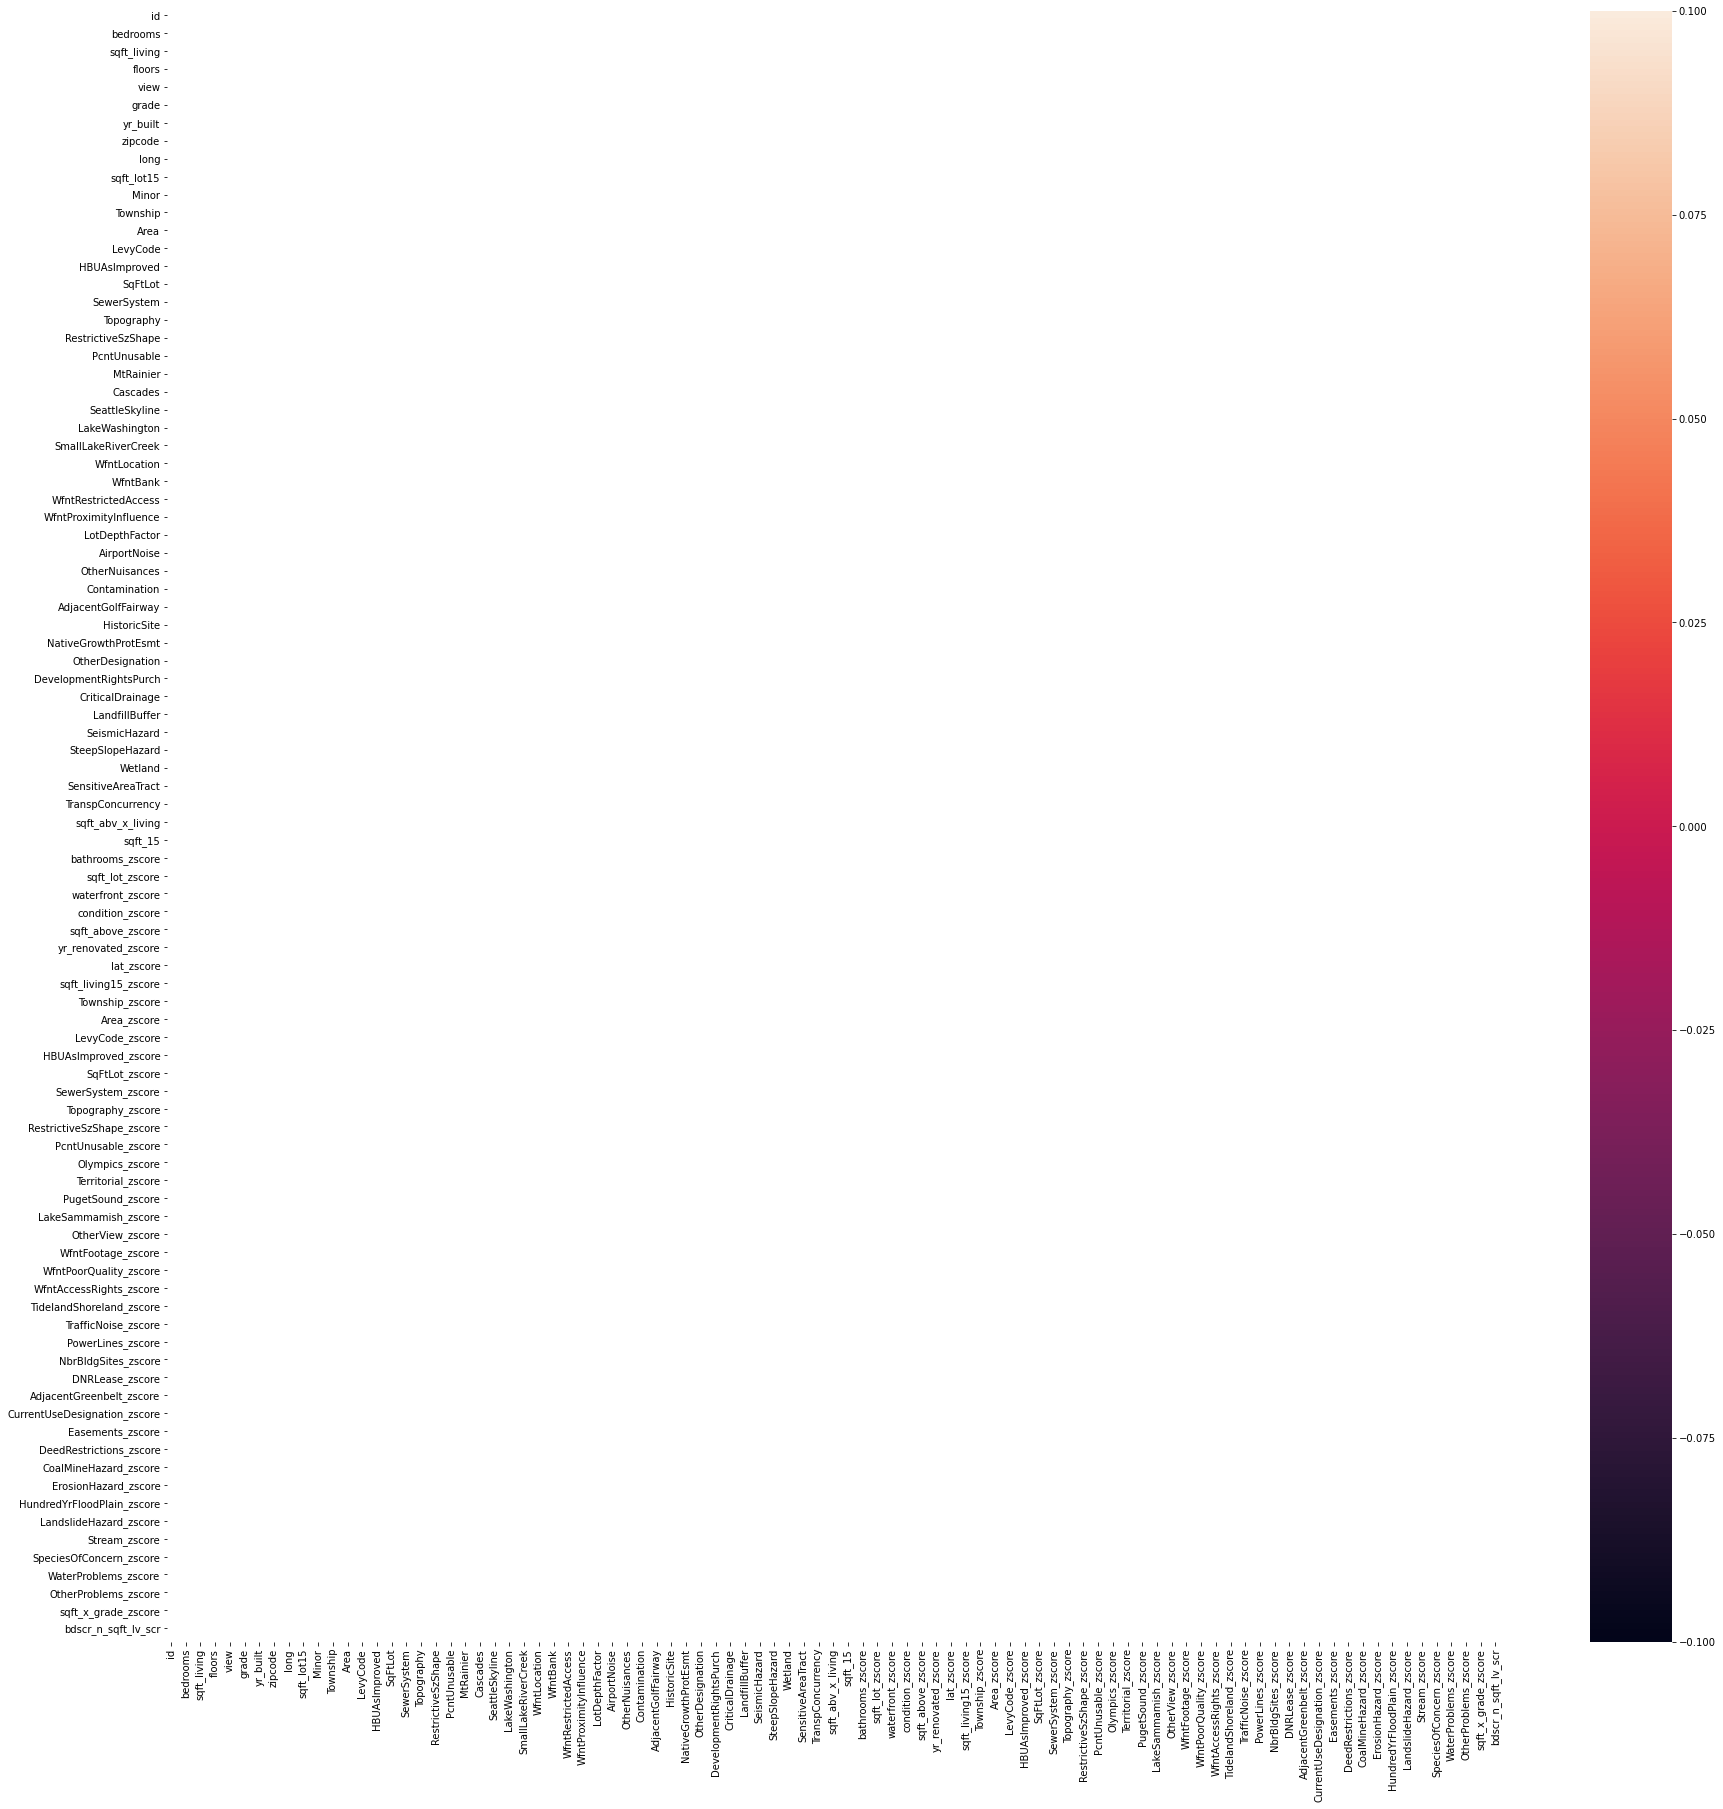

In [9]:
fig_dims = (30, 30)
fig, ax = plt.subplots(figsize = fig_dims)
sns.heatmap(kc_data.corr(), ax=ax)
plt.show()

In [10]:


# initialize regression
reg = linear_model.LinearRegression()
# split data into 80/20 training/testing
x_train, x_test, y_train, y_test = train_test_split(kcx, kcy, test_size=0.2, random_state=42)
# train the model 
reg.fit(x_train, y_train)
# print test data predictions 
y_pred = reg.predict(x_test)

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
# check accuracy with mean sq 
#np.mean((y_pred - y_test)**2)

In [ ]:
#Trying KNN
# maybe try 60% train , 20% adj, 20% test?
cv = KFold(n_splits=10)
classifier_pipeline = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=10))
k_pred = cross_val_predict(classifier_pipeline, kcx, kcy, cv=5)

vals = [0.1, 0.2, 0.3, 0.4, 0.5]

for val in vals:
    features = abs(kc_data.corr())['price'][abs(kc_data.corr()['price'])>val].drop('price').index.tolist()
    
    x = kc_data.drop(columns='price')
    x = x[features]
    
    y_pred = cross_val_predict(classifier_pipeline, x, kcy, cv=cv)
    
    print(features)
    print('RMSE:  ' + str(round(sqrt(mean_squared_error(kcy, y_pred)), 2)))
    print('R Squared: ' + str(round(r2_score(kcy, y_pred), 2)))

In [ ]:
# Define the problem using features selected above 
outcome = 'price'
# use your columns with lowers RMSE & highest R2 
x_cols = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'view', 'grade', 'sqft_above', 'lat', 'sqft_living15', 'sqft_abv_x_living', 'sqft_15', 'sqft_x_grade', 'bedrooms_zscore', 'bathrooms_zscore', 'sqft_living_zscore', 'floors_zscore', 'grade_zscore', 'sqft_above_zscore', 'sqft_living15_zscore']

# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=kc_data).fit()
model.summary()

In [ ]:
# Extract the p-value table from the summary and use it to subset our features
summary = model.summary()

p_table = summary.tables[1]
p_table = pd.DataFrame(p_table.data)
p_table.columns = p_table.iloc[0]
p_table = p_table.drop(0)
p_table = p_table.set_index(p_table.columns[0])
p_table['P>|t|'] = p_table['P>|t|'].astype(float)


x_cols = list(p_table[p_table['P>|t|'] < 0.05].index)
x_cols.remove('Intercept')

print(x_cols[:])
p_table.head()

In [ ]:
#investigated multicoliniarity, didn't help, removed non-significant features
#didn't help, went back and filtered everything by z score, no change
# trying 

In [ ]:
#kc_data['condition'] = kc_data['condition'].astype(int)
#condition_dummies = pd.get_dummies(kc_data['condition'], prefix='cond', drop_first=True)
#grade_dummies = pd.get_dummies(kc_data['grade'], prefix='grade', drop_first=True)
#bedroom_dummies = pd.get_dummies(kc_data['bedrooms'], prefix='bed', drop_first=True)
#zipcode_dummies = pd.get_dummies(kc_data['zipcode'], drop_first=True)
#kc_data = pd.concat([kc_data], axis=1)

#got dummies, not helpful so far 

In [ ]:
#binning my sqft & manually getting dummies 
#kc_data['sndqrt15'] = kc_data['sqft_living15'].between(1460, 1790, inclusive=False) 
#kc_data['trdqrt15'] = kc_data['sqft_living15'].between(1790, 2240, inclusive=False) 
#kc_data['fthqrt15'] = kc_data['sqft_living15'] > 2240
#kc_data['sndqrt15'] = kc_data['sndqrt15'] * 1 
#kc_data['trdqrt15'] = kc_data['trdqrt15'] * 1 
#kc_data['fthqrt15'] = kc_data['fthqrt15'] * 1 

In [ ]:
#kc_data = kc_data.drop('sqft_living15', axis=1).drop('sqft_living', axis=1)

In [ ]:
k = 20 #number of variables for heatmap
corrmat = kc_data.corr()
cols = corrmat.nlargest(k, 'price')['price'].index
cm = np.corrcoef(kc_data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [ ]:

x_cols = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'view', 'sqft_x_grade', 'ratio_bd_bth', 'sqft_abv_x_living', 'sqft_15', 'sqft_x_grade', 'bedrooms_zscore', 'bathrooms_zscore', 'sqft_living_zscore', 'floors_zscore', 'grade_zscore', 'sqft_above_zscore', 'sqft_living15_zscore', 'bdscr_n_sqft_lv_scr', 'lat_n_long']

#for feat in x_cols:
#    kc_data[feat] = kc_data[feat].map(lambda x: np.log(x))

In [ ]:
#pd.plotting.scatter_matrix(kc_data, figsize=(10,12));

In [ ]:
kc_data = kc_data[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'view', 'grade', 
                   'sqft_above', 'lat', 'sqft_living15', 'ratio_bd_bth', 'sqft_abv_x_living', 
                   'sqft_15', 'sqft_x_grade']]

In [ ]:
# initialize regression
reg = linear_model.LogisticRegression()

In [ ]:
# Define the problem using features selected above 
outcome = 'price'
# use your columns with lowers RMSE & highest R2 
# Fitting the actual model

x_cols = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'view', 'grade', 'sqft_above', 
          'lat', 'sqft_living15', 'ratio_bd_bth', 'sqft_abv_x_living', 'sqft_15', 'sqft_x_grade',
          'bedrooms_zscore', 'bathrooms_zscore', 'sqft_living_zscore', 'floors_zscore', 'grade_zscore', 'sqft_above_zscore', 'sqft_living15_zscore']

predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=kc_data).fit()
model.summary()